***CONSTRUCCION DEL MODELO ARIMA EN PYTHON PARA EL PRONOSTICO DE SERIES TEMPORALES***

Tres Factores definen el modelo ARIMA, se define como $ARIMA(p,d,q)$ donde $p,d$ y $q$ denotan el número de observaciones rezagadas (o pasadas) a considerar para la autoregresión, el número de veces que se diferencian las observaciones sin procesar, y el tamaño de la ventana de promedio móvil respectivamente.

La siguiente ecuación muestra un modelo autorregresivo típico. Como sugiere el nombre, los nuevos valores de este modelo dependen puramente de una combinación lineal ponderada de sus valores anteriores. Dado que hay $p$ valores pasados, esto se denota como $AR(p)$ o un modelo autorregresivo de orden $p$. Epsilon$(ϵ)$ indica el ruido blanco.

$Y_{T} = \alpha + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + . . . + \beta_{p}Y_{t-p} + \epsilon$

A continuación, la media móvil se define de la siguiente manera:

$y_{t} = c + ϵ_{t} + \theta_{1}ϵ_{t-1} + \theta_{2}ϵ_{t-2} + . . . + \theta_{q}ϵ_{t-q}$

Aquí, el valor futuro $y(t)$ se calcula en función de los errores $ϵ_{t}$ cometidos por el modelo anterior. Entonces, cada término sucesivo mira un paso más hacia el pasado para incorporar los errores cometidos por ese modelo en el cálculo actual. Basados en la ventana que estamos dispuestos a mirar más allá, se establece el valor $q$. Por lo tanto, el modelo anterior se puede denotar de forma independiente como una media movil de orden $q$ o simplemente $MA(q)$.\\

***¿Por qué ARIMA necesita datos estacionarios de series temporales? ***

Los modelos autoregresivos son conceptualmente similares a la regresión lineal, las suposiciones hechas por este último también son válidas aquí. Los datos de series de t5iempo deben ser estacionarios para eliminar cualquier correlación y colinealidad obvia con los datos anteriores. En los datos de series de tiempo estacionarios, las propiedades o el valor de una observación de muestra no dependen de la marca de tiempo en la que se observa. Por ejemplo, dado un conjunto de datos hipotético de la población anual de un área, si se observa que la población aumenta al doble cada año o aumenta en una cantidad fija, entonces tos datos no son estacionarios. Cualquier observación dada depende en gran medida del año, ya que el valor de la poblacion dependeria de que tan lejos este de un año pasado arbitrario. Esta dependencia puede inducir un sesgo incorrecto al entrenar un modelo con datos de series temporales.

Para eliminar esta correlación, ARIMA utiliza la diferenciacion para hacer que los datos sean estacionarios. La diferenciacion, en su forma más simple, implica tomar la diferencia de dos puntos de datos adyacentes. 

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importacion de Bibliotecas
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

plt.style.use('ggplot')
import yfinance as yf

In [ ]:
inicio = "2015-08-20"
fin = "2022-08-20"
data = yf.download("AMZN",inicio,fin)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df = pd.DataFrame()
df["Close"]          = data["Close"]
df["Close_log"]      = data["Close"].apply(np.log)
df["Close_log_diff"] = df["Close_log"].diff()
df.dropna(inplace=True, axis = "rows")
df.head()

,Close,Close_log,Close_log_diff
Date,,,
2015-08-21,24.723499,3.207754,-0.042194
2015-08-24,23.168501,3.142794,-0.064961
2015-08-25,23.318501,3.149247,0.006453
2015-08-26,25.038500,3.220415,0.071168
2015-08-27,25.918501,3.254957,0.034542


Analisis Exploratorio de Datos

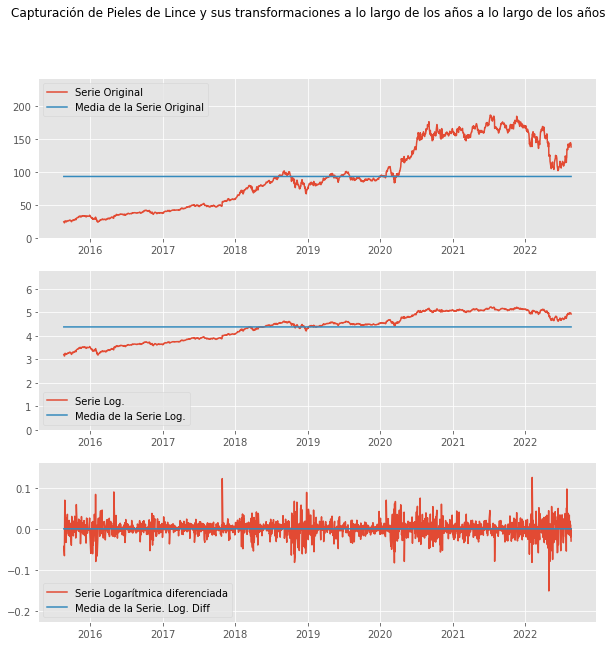

In [ ]:
# separar x y la y para el gráfico
x = df.index

y = df["Close"]
y_media = [np.mean(y) for _ in y]

y_log = df["Close_log"]
y_log_media = [np.mean(y_log) for _ in y_log]

y_log_diff = df["Close_log_diff"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)

# la serie original parece ser no estacionaria
# si nos fijamos en su comportamiento, vemos muchos picos y que la media de diferentes
# tramos de la serie es diferente.
# además la covarianza entre diferentes tramos también parece distinta.
ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

# Si transformamos la serie utilizando el logaritmo neperiano (ln)
# tenemos una serie que YA es estacionaria en media y que oscila entorno
# a 7.
ax2.plot(x, y_log, label = "Serie Log.")
ax2.plot(x, y_log_media, label = "Media de la Serie Log.")
ax2.set_ylim(0, np.max(y_log)*1.3)
ax2.legend(loc = "lower left")

# Si aplicamos una diferenciación a al serie logarítmica, seguimos teniendo
# una serie estacionaria, pero esta vez, la media de la serie oscila entorno al cero.

# La diferenciación de una serie estacionaria SIEMPRE da lugar a otra serie estacionaria.
# Por este motivo, no haría falta hacer la diferencia y con la serie transformada (logarítmica)
# es suficiente.

ax3.plot(x, y_log_diff, label = "Serie Logarítmica diferenciada")
ax3.plot(x, y_log_diff_mean, label = "Media de la Serie. Log. Diff")
ax3.set_ylim(np.min(y_log_diff)*1.5, np.max(y_log_diff)*1.3)
ax3.legend(loc = "lower left")

fig.suptitle("Capturación de Pieles de Lince y sus transformaciones a lo largo de los años a lo largo de los años");

Comprobacion de la estacionariedad 

In [ ]:
for serie, nombre_serie in zip([y, y_log, y_log_diff], ["Serie Original", "Serie Log.", "Serie. Log. Diff"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))
    

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -1.2347616921866467

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.6584662712200746

------------------------------------------------------------------
Estamos trabajando con la serie Serie Log.

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -1.8088933794206825

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.3760554023030927

------------------------------------------------------------------
Estamos trabajando con la serie Serie. Log. Diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -14.122110664242848

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 2.4147257064774002e-26



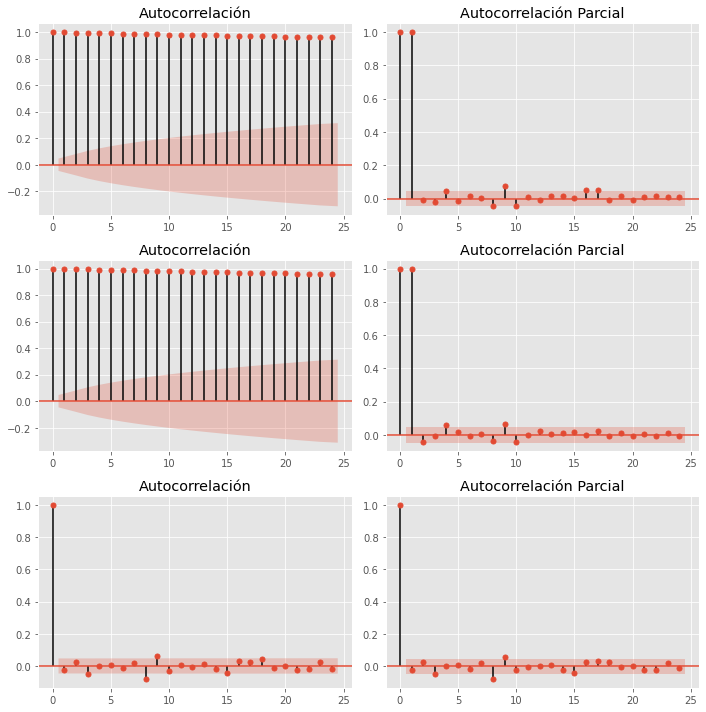

In [ ]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log, ax = ax3, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log, ax = ax4, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log_diff, ax = ax5, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log_diff, ax = ax6, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()

In [ ]:
y = df["Close_log_diff"].resample("D").mean()
y = y.fillna(y.bfill())

print(y)

Date
2015-08-21   -0.042194
2015-08-22   -0.064961
2015-08-23   -0.064961
2015-08-24   -0.064961
2015-08-25    0.006453
                ...   
2022-08-15   -0.002581
2022-08-16    0.011113
2022-08-17   -0.018684
2022-08-18    0.001406
2022-08-19   -0.029019
Freq: D, Name: Close_log_diff, Length: 2556, dtype: float64


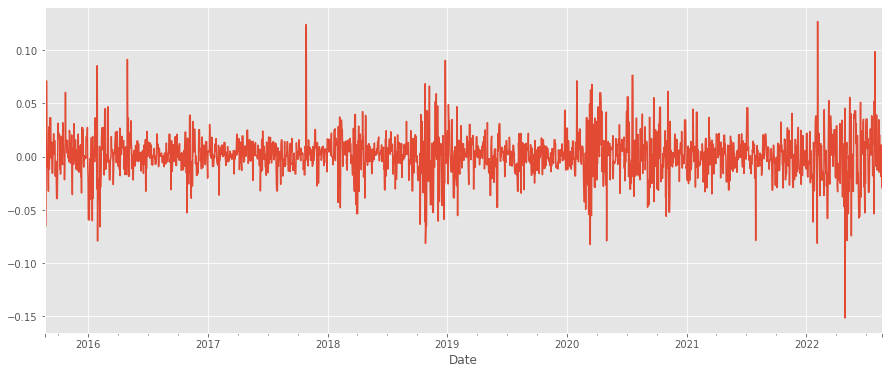

In [ ]:
y.plot(figsize = (15,6))
plt.show()

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal


        except:
            continue


et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-12579.558132673006
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-12556.345061705146
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-10761.006620266831
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-12428.079168524333
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-12560.481755547284
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-12554.568007819249
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-11524.340375049354
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-12444.38562500134
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-12779.370979725321
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-12742.580815306812
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-10929.802669077264
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-12620.647519098138
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-12752.179663634175
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-12740.790323133377
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-11714.431481804844
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-12629.812840901763
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-11765.915475826407
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 -

In [ ]:
print("El mejor modelo es {}, \n Con un AIC de {}".format(best_params, best_score))

El mejor modelo es (0, 1, 0), 
 Con un AIC de -9893.411796688682


In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   1.69e-05     70.667      0.000       0.001       0.001


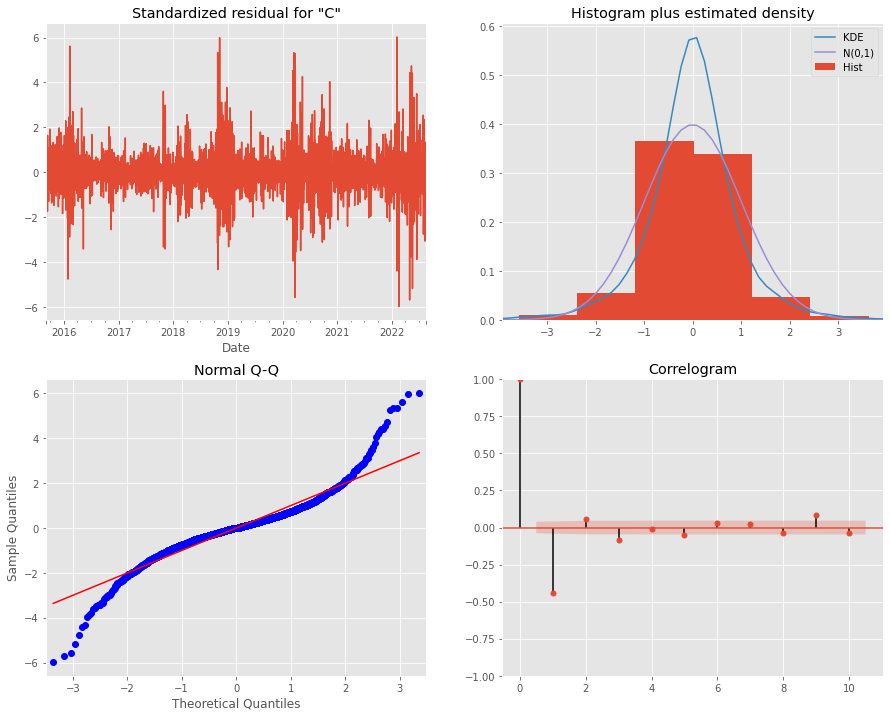

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()

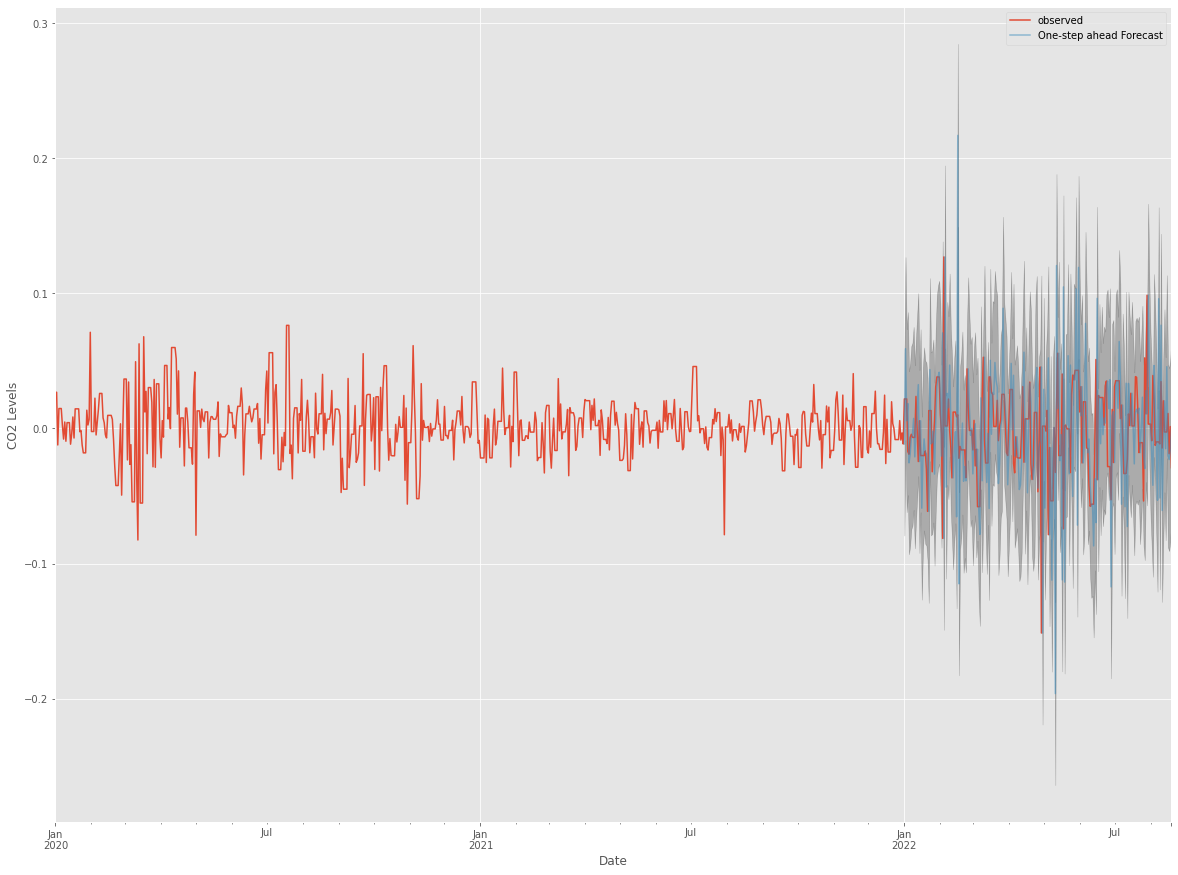

In [ ]:
ax = y['2020':].plot(label='observed',figsize = (20,15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.5)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()